In [1]:
using Symbolics, FastGaussQuadrature, Plots, QuadGK, LinearAlgebra, Revise

#Define Piecewise Linear Functions
function Na(x, mesh, index, delta)
    if x < 0 #Handle Gauss-legendre
        return 0
    end
    if index == 1 #Edge case handling
        if x < mesh[index+1]
            u = (mesh[index+1] - x)/ delta
            return u
        else
            return 0
        end
    elseif x < mesh[index-1] #Note: Index must be greated than 2
        return 0
    elseif x < mesh[index] # Piece from NA-1 to NA
        return (x - mesh[index-1]) / (delta)
    elseif x < mesh[index+1]
        return (mesh[index+1] - x) / (delta)
    else
        return 0
    end
end

function Naprime(x, mesh, index, delta)
    if x < 0 #Handle Gauss-legendre
        return 0
    end
    if index == 1 #Edge case handling
        if x < mesh[index+1]
            return (-1)/ delta
        else
            return 0
        end
    elseif x < mesh[index-1] #Note: Index must be greated than 2
        return 0
    elseif x < mesh[index] # Piece from NA-1 to NA
        return (1) / (delta)
    elseif x < mesh[index+1]
        return (-1) / (delta)
    else
        return 0
    end
end

function Nn1(x, mesh, delta)    
    if x < 0#Handle Gauss-legendre
        return 0
    elseif x < mesh[length(mesh)-1]
        return 0
    else
        u = (x - mesh[length(mesh)-1])/delta
        return u
    end
end

function construct_K_elem(a, k, mesh, row, col, delta)
    #Using sym
    x, w = gausslegendre(100); #integrates from -1 to 1 but all basis functions are 0 for x < 0
    f(x) = k * Naprime(x, mesh, row, delta) * Naprime(x, mesh, col, delta) - a * Na(x, mesh, row, delta) * Naprime(x, mesh, col, delta)
    I = dot(w, f.(x));
    return I
end

function construct_F_elem(a, k, mesh, row, delta, boundaries)
    x, w = gausslegendre(100)
    if row == 1
        p(x) = Na(x, mesh, row, delta) * 12*x^2
        I = dot(w, p.(x)) + boundaries[1]
        return I
    elseif row == length(mesh)-1
        q(x) = Na(x, mesh, row, delta) * 12*x^2 + Naprime(x, mesh, row, delta)*Naprime(x, mesh, row, delta)*boundaries[2]        
        I = dot(w, q.(x))
        return I
    else
        f(x) = Na(x, mesh, row, delta) * 12*x^2
        I = dot(w, f.(x))
        return I
    end
end

function construct_K(a, k, mesh, numrow, numcol, delta)
    KMat = zeros(numrow, numcol)
    for i = 1:numrow
        for j = 1:numcol
            KMat[i, j] = construct_K_elem(a, k, mesh, i, j, delta)
        end
    end
    return KMat
end

function construct_F(a, k, mesh, numrow, delta)
    FVec = zeros(numrow)
    for i = 1:numrow
        FVec[i] = construct_F_elem(a, k, mesh, i, delta, [0,1])
    end
    return FVec
end

function ADR_galerkin(n::Int, a::Int, k::Int, boundaries)
    @variables x
    delta = 1. / (n)
    mesh = collect(0:(1. / (n)):1) #n+1 points for n subintervals; x1 = 0; x_n+1 = 1
    d = construct_F(a, k, mesh, n, delta) \ construct_K(a,k, mesh, n, n, delta)
    prog = "uh(x) = "
    for i in 1:length(d)
        coeff = d[i]
        prog = prog * "+ $coeff*Na(x, $mesh, $i, $delta)"
    end
    prog = prog * "+ (x - $mesh[$n])/$delta"
    exp = Meta.parse(prog)
    eval(exp)
    print("\n1D Uniform Mesh: ", mesh, " with spacing: ", delta, "\n")
    plot(uh, xlim=(0,1), title="h-1 = $n, Peclet = $a/$k")
end

ADR_galerkin (generic function with 1 method)


1D Uniform Mesh: [0.0, 1.0] with spacing: 1.0


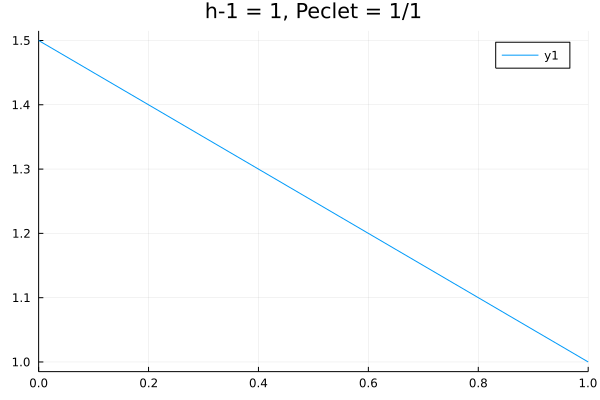

In [3]:
ADR_galerkin(1, 1, 1, [0,1])


1D Uniform Mesh: [0.0, 0.5, 1.0] with spacing: 0.5


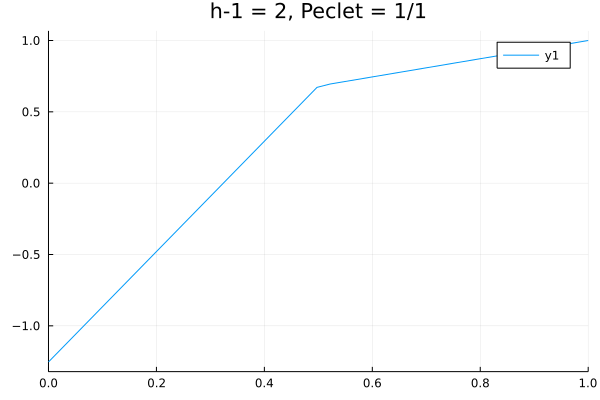

In [5]:
ADR_galerkin(2, 1, 1, [0,1])


1D Uniform Mesh: [0.0, 0.25, 0.5, 0.75, 1.0] with spacing: 0.25


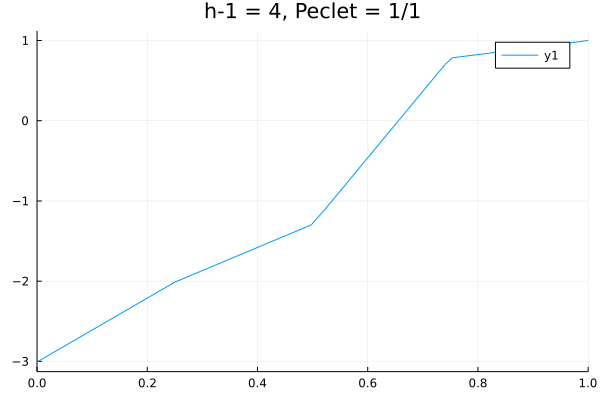

In [7]:
ADR_galerkin(4, 1, 1, [0,1])


1D Uniform Mesh: [0.0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1.0] with spacing: 0.125


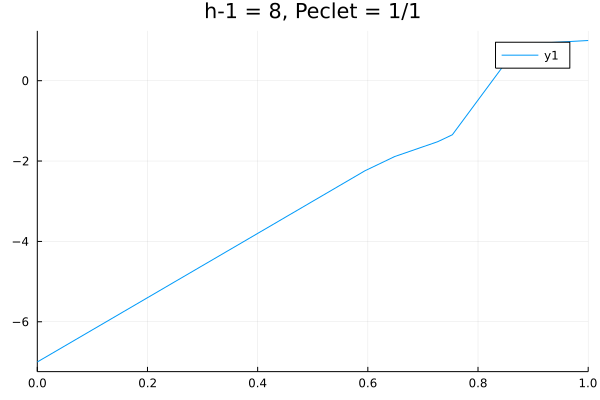

In [9]:
ADR_galerkin(8, 1, 1, [0,1])


1D Uniform Mesh: [0.0, 0.0625, 0.125, 0.1875, 0.25, 0.3125, 0.375, 0.4375, 0.5, 0.5625, 0.625, 0.6875, 0.75, 0.8125, 0.875, 0.9375, 1.0] with spacing: 0.0625


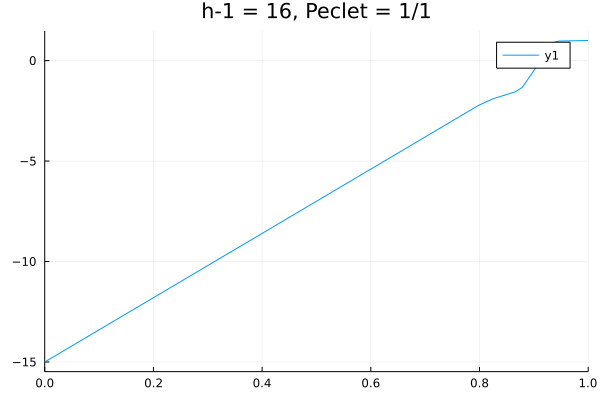

In [11]:
ADR_galerkin(16, 1, 1, [0,1])


1D Uniform Mesh: [0.0, 0.5, 1.0] with spacing: 0.5


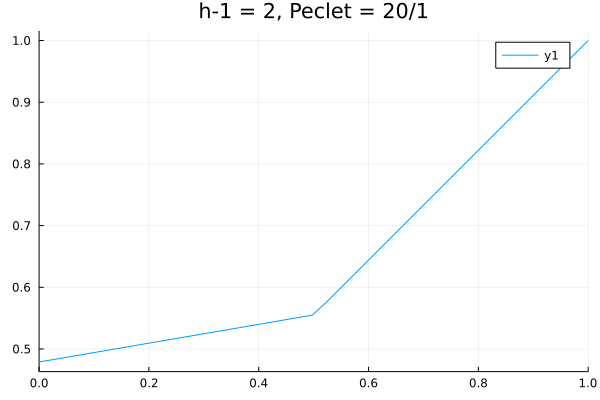

In [13]:
ADR_galerkin(2, 20, 1, [0,1])


1D Uniform Mesh: [0.0, 0.25, 0.5, 0.75, 1.0] with spacing: 0.25


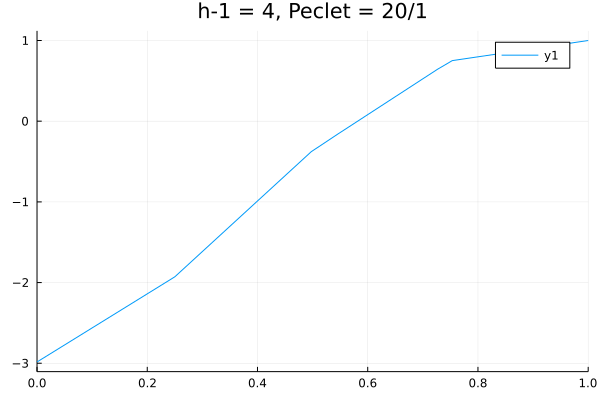

In [15]:
ADR_galerkin(4, 20, 1, [0,1])